# What impacts the earning of the taxi drivers?

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read preprocessed trip data

processed_yellow_01 = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-01")
processed_yellow_02 = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-02")
processed_yellow_03 = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-03")


In [ ]:
# Append preprocessed trip data together and output

processed_yellow_tripdata = processed_yellow_01.append(processed_yellow_02).append(processed_yellow_03)

processed_yellow_tripdata = processed_yellow_tripdata.reset_index().drop('index', axis=1)

processed_yellow_tripdata.to_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3")

## Feature engineering

In [ ]:
# Load preprocessed trip data

processed_yellow_tripdata = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3")

processed_yellow_tripdata

In [ ]:
# Double check the null value

processed_yellow_tripdata.isnull().sum()

In [ ]:
# Remove inrelevant data

yellow_tripdata = processed_yellow_tripdata.drop(['VendorID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'payment_type'], axis=1)
yellow_tripdata

In [ ]:
# Add pick-up date column for aggregating the data later

yellow_tripdata['pickup_date'] = yellow_tripdata['tpep_pickup_datetime'].dt.normalize()

In [ ]:
# Add day type column (whether weekday or weekend)

yellow_tripdata['day'] = yellow_tripdata['pickup_date'].dt.dayofweek
yellow_tripdata.loc[yellow_tripdata['day'] >= 6, 'day_type'] = 'Weekend'
yellow_tripdata.loc[yellow_tripdata['day'] < 6, 'day_type'] = 'Weekday'
yellow_tripdata = yellow_tripdata.drop('day', axis=1)
yellow_tripdata['pickup_date'] = yellow_tripdata['pickup_date'].astype(str)


In [ ]:
# Add tip ratio to the total amount

yellow_tripdata['tip_ratio'] = round(yellow_tripdata['tip_amount'] / yellow_tripdata['total_amount'], 2)


In [ ]:
# Add fare/hour column

yellow_tripdata['fare/hour'] = round(yellow_tripdata['total_amount'] / yellow_tripdata['time_duration'] * 60, 2)


In [ ]:
# Add mile/hour column and filter unusually high speed

yellow_tripdata['mile/hour'] = round(yellow_tripdata['trip_distance'] / yellow_tripdata['time_duration'] * 60, 2)


In [ ]:
yellow_tripdata

In [ ]:
yellow_tripdata = yellow_tripdata.reset_index().drop('index', axis=1)
yellow_tripdata.to_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_fe")

## Add external Climate data

In [ ]:
yellow_tripdata_fe = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_fe")

In [ ]:
weather = pd.read_feather("../preprocessed_data/processed_weather")

In [ ]:
yellow_tripdata_weather = pd.merge(yellow_tripdata_fe, weather, left_on='pickup_date', right_on='DATE').drop('DATE', axis=1)

yellow_tripdata_weather

In [ ]:
yellow_tripdata_weather.to_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_fe_weather")

## Removing outliers

In [ ]:
# Load preprocessed trip data after feature engineering

yellow_tripdata = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_fe_weather")

yellow_tripdata

In [ ]:
# Divide into standard-rate trip and JFK-rate trip

yellow_tripdata_standard = yellow_tripdata[yellow_tripdata['RatecodeID'] == 1]
yellow_tripdata_jfk = yellow_tripdata[yellow_tripdata['RatecodeID'] == 2]


In [ ]:
# remove same pick-up and drop-off location for JFK trip (should be in preprocessing)

yellow_tripdata_jfk = yellow_tripdata_jfk[yellow_tripdata_jfk['PULocationID'] != yellow_tripdata_jfk['DOLocationID']]


#### Removing outlier for fees (standard rate)

In [ ]:
# Draw the box plot to see if there's any outlier for fees (standard rate)

amount = ['fare_amount', 'tip_amount', 'total_amount']

fee_boxplot = yellow_tripdata_standard.boxplot(column=amount, fontsize=10, figsize=(6,6))
fig = fee_boxplot.get_figure()

fig.suptitle("Box Plot of Fees under Standard Rate with outliers")
plt.xlabel('Type of amount')
plt.ylabel('Fees (dollars)')
fig.show()
fig.savefig("../plots/Box Plot of Fees under Standard Rate with outliers")

In [ ]:
# Remove outliers by quantile
# https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles

Q1 = yellow_tripdata_standard[amount].quantile(0.25)
Q3 = yellow_tripdata_standard[amount].quantile(0.75)
IQR = Q3 - Q1

yellow_standard_no_fee_outliers = yellow_tripdata_standard[~((yellow_tripdata_standard[amount] < (Q1 - 3 * IQR)) | (yellow_tripdata_standard[amount] > (Q3 + 3 * IQR))).any(axis=1)]

yellow_standard_no_fee_outliers

In [ ]:
# Draw the box plot after removing outliers (standard rate)

fee_boxplot = yellow_standard_no_fee_outliers.boxplot(column=amount, fontsize=10, figsize=(6,6))
fig = fee_boxplot.get_figure()

fig.suptitle("Box Plot of Fees under Standard Rate without outliers")
plt.xlabel('Type of amount')
plt.ylabel('Fees (dollars)')
fig.show()
fig.savefig("../plots/Box Plot of Fees under Standard Rate without outliers")

#### Removing outlier for fees (JFK rate)

In [ ]:
# Draw the box plot to see if there's any outlier for fees (JFK rate)

amount = ['fare_amount', 'tip_amount', 'total_amount']

fee_boxplot = yellow_tripdata_jfk.boxplot(column=amount, fontsize=10, figsize=(6,6))
fig = fee_boxplot.get_figure()

fig.suptitle("Box Plot of Fees under JFK Rate with outliers")
plt.xlabel('Type of amount')
plt.ylabel('Fees (dollars)')
fig.show()
fig.savefig("../plots/Box Plot of Fees under JFK Rate with outliers")

In [ ]:
# Remove outliers by quantile

Q1 = yellow_tripdata_jfk[amount].quantile(0.25)
Q3 = yellow_tripdata_jfk[amount].quantile(0.75)
IQR = Q3 - Q1

yellow_jfk_no_fee_outliers = yellow_tripdata_jfk[~((yellow_tripdata_jfk[amount] < (Q1 - 3 * IQR)) | (yellow_tripdata_jfk[amount] > (Q3 + 3 * IQR))).any(axis=1)]

yellow_jfk_no_fee_outliers

In [ ]:
# Draw the box plot after removing outliers (JFK rate)

fee_boxplot = yellow_jfk_no_fee_outliers.boxplot(column=amount, fontsize=10, figsize=(6,6))
fig = fee_boxplot.get_figure()

fig.suptitle("Box Plot of Fees under JFK Rate without outliers")
plt.xlabel('Type of amount')
plt.ylabel('Fees (dollars)')
fig.show()
fig.savefig("../plots/Box Plot of Fees under JFK Rate without outliers")

#### Removing outlier for distance (standard rate)

In [ ]:
# Draw the box plot to see if there's any outlier for trip distance (standard rate)

distance_boxplot = yellow_standard_no_fee_outliers.boxplot(column='trip_distance', fontsize=10, figsize=(6,6))
fig = distance_boxplot.get_figure()

fig.suptitle("Box Plot of Trip Distance under Standard Rate with outliers")
plt.ylabel('Distance (miles)')
fig.show()
fig.savefig("../plots/Box Plot of Trip Distance under Standard Rate with outliers")

In [ ]:
# Same as removing outliers for fees to remove outliers for distance 

Q1 = yellow_tripdata_standard['trip_distance'].quantile(0.25)
Q3 = yellow_tripdata_standard['trip_distance'].quantile(0.75)
IQR = Q3 - Q1

yellow_standard_no_distance_outliers = yellow_standard_no_fee_outliers[~((yellow_standard_no_fee_outliers['trip_distance'] < (Q1 - 3 * IQR)) | (yellow_standard_no_fee_outliers['trip_distance'] > (Q3 + 3 * IQR)))]

yellow_standard_no_distance_outliers

In [ ]:
# Draw the box plot after removing outliers (standard rate)

distance_boxplot = yellow_standard_no_distance_outliers.boxplot(column='trip_distance', fontsize=10, figsize=(6,6))
fig = distance_boxplot.get_figure()

fig.suptitle("Box Plot of Trip Distance under Standard Rate without Outliers")
plt.ylabel('Distance (miles)')
fig.show()
fig.savefig("../plots/Box Plot of Trip Distance under Standard Rate without Outliers")

#### Removing outlier for distance (JFK rate)

In [ ]:
# Draw the box plot to see if there's any outlier for trip distance (JFK rate)

distance_boxplot = yellow_jfk_no_fee_outliers.boxplot(column='trip_distance', fontsize=10, figsize=(6,6))
fig = distance_boxplot.get_figure()

fig.suptitle("Box Plot of Trip Distance under JFK Rate with outliers")
plt.ylabel('Distance (miles)')
fig.show()
fig.savefig("../plots/Box Plot of Trip Distance under JFK Rate with outliers")

In [ ]:
# Same as removing outliers for fees to remove outliers for distance 

Q1 = yellow_tripdata_jfk['trip_distance'].quantile(0.25)
Q3 = yellow_tripdata_jfk['trip_distance'].quantile(0.75)
IQR = Q3 - Q1

yellow_jfk_no_distance_outliers = yellow_jfk_no_fee_outliers[~((yellow_jfk_no_fee_outliers['trip_distance'] < (Q1 - 3 * IQR)) | (yellow_jfk_no_fee_outliers['trip_distance'] > (Q3 + 3 * IQR)))]

yellow_jfk_no_distance_outliers


In [ ]:
# Draw the box plot after removing outliers (standard rate)

distance_boxplot = yellow_jfk_no_distance_outliers.boxplot(column='trip_distance', fontsize=10, figsize=(6,6))
fig = distance_boxplot.get_figure()

fig.suptitle("Box Plot of Trip Distance under JFK Rate without Outliers")
plt.ylabel('Distance (miles)')
fig.show()
fig.savefig("../plots/Box Plot of Trip Distance under JFK Rate without Outliers")

#### Output the data after outliers removed

In [ ]:
# Output the data without outliers

yellow_standard_no_outliers = yellow_standard_no_distance_outliers.reset_index().drop('index', axis=1)

yellow_standard_no_outliers.to_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_standard_no_outliers")


In [ ]:
# Output the data without outliers

yellow_jfk_no_outliers = yellow_jfk_no_distance_outliers.reset_index().drop('index', axis=1)

yellow_jfk_no_outliers.to_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_jfk_no_outliers")

## Geospatial Visualisation

In [ ]:
import geopandas as gpd

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook

from bokeh.models import ColorBar, LinearColorMapper
from bokeh.palettes import all_palettes

In [ ]:
# Load processed separated trip data

yellow_standard_no_outliers = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_standard_no_outliers")
yellow_jfk_no_outliers = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_jfk_no_outliers")

yellow_no_outliers = yellow_standard_no_outliers.append(yellow_jfk_no_outliers)

In [ ]:
yellow_no_outliers = yellow_no_outliers.reset_index().drop('index', axis=1)

yellow_no_outliers.to_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_no_outliers")

In [ ]:
# sf stands for shape file
sf = gpd.read_file("../raw_data/taxi_zones/taxi_zones.shp")

# Convert the geometry shape to to latitude and longitude
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")


In [ ]:
# From prepreocessing code file, it's found that there are invalid data in the shape file, so fix it

sf.loc[56,'LocationID'] = 57
sf.loc[103,'LocationID'] = 104
sf.loc[104,'LocationID'] = 105

sf

In [ ]:
# Load processed combined trip data

yellow_no_outliers = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_no_outliers")

yellow_no_outliers['count'] = 1

In [ ]:
data_by_date = yellow_no_outliers.groupby(by='pickup_date')

days_amount = len(data_by_date)

data_by_date_sum = data_by_date.sum()
data_by_date_sum

#### Average Tip Ratio Map (Pickup region)

In [ ]:
data_by_pu = yellow_no_outliers.groupby(by='PULocationID')
data_by_pu_sum = data_by_pu.sum()

data_by_pu_sum

In [ ]:
tip_count = data_by_pu_sum['tip_ratio']
trip_count = data_by_pu_sum['count']

Tip_ratio = pd.DataFrame({'LocationID': tip_count.index, 'tip_ratio': round(tip_count / trip_count, 3)})

Tip_ratio

In [ ]:
gdf_pu_tip = gpd.GeoDataFrame(pd.merge(Tip_ratio, sf, left_on='LocationID', right_on='LocationID'))
gdf_pu_tip['tip_ratio'] = gdf_pu_tip['tip_ratio'].fillna(0)

gdf_pu_tip = gdf_pu_tip[gdf_pu_tip['borough'] == 'Manhattan']
gdf_pu_tip

In [ ]:
geoJSON = gdf_pu_tip[['LocationID','geometry']].to_json()

In [ ]:
# Map showing pick-up amount in every yellow-taxi zone in Manhattan

m_pu_tip = folium.Map(location=[40.781, -73.966], tiles="Stamen Terrain", zoom_start=11)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_pu_tip, # data source
    columns=['LocationID','tip_ratio'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='BuPu', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Average Tip ratio' # legend title
).add_to(m_pu_tip)

# folium.Marker([40.756, -73.985],popup="<b>Times Sqaure</b>").add_to(m_pu_tip)

folium.CircleMarker(
    location=[40.758, -73.985],
    radius=8,
    popup="Times Sqaure",
    color="white",
    fill=True,
    fill_color="white",
).add_to(m_pu_tip)

folium.CircleMarker(
    location=[40.750, -73.993],
    radius=8,
    popup="Madison Square Garden",
    color="white",
    fill=True,
    fill_color="white",
).add_to(m_pu_tip)

folium.CircleMarker(
    location=[40.870, -73.925],
    radius=8,
    popup="InWood Hill Park",
    color="green",
    fill=True,
    fill_color="green",
).add_to(m_pu_tip)

folium.CircleMarker(
    location=[40.703, -74.015],
    radius=8,
    popup="Financial District",
    color="yellow",
    fill=True,
    fill_color="yellow",
).add_to(m_pu_tip)

folium.CircleMarker(
    location=[40.762, -73.950],
    radius=8,
    popup="Roosevelt Island",
    color="blue",
    fill=True,
    fill_color="blue",
).add_to(m_pu_tip)

m_pu_tip.save('../plots/foliumChoroplethMapPickUpTipRatio.html')
m_pu_tip

#### Average Pickup Count Map

In [ ]:
pu_count = data_by_pu_sum['count']

PU_count = pd.DataFrame({'LocationID': pu_count.index, 'PU_count': round(pu_count / days_amount)})

PU_count

In [ ]:
gdf_pu_count = gpd.GeoDataFrame(pd.merge(PU_count, sf, left_on='LocationID', right_on='LocationID'))
gdf_pu_count['PU_count'] = gdf_pu_count['PU_count'].fillna(0)

gdf_pu_count = gdf_pu_count[gdf_pu_count['borough'] == 'Manhattan']
gdf_pu_count

In [ ]:
geoJSON = gdf_pu_count[['LocationID','geometry']].to_json()

In [ ]:
# Map showing pick-up amount in every yellow-taxi zone in Manhattan

m_pu_count = folium.Map(location=[40.781, -73.966], tiles="Stamen Terrain", zoom_start=11)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_pu_count, # data source
    columns=['LocationID','PU_count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Number of Pickups Per Day' # legend title
).add_to(m_pu_count)

m_pu_count.save('../plots/foliumChoroplethMapPickUpCount.html')
m_pu_count

#### Average Dropoff Count Map

In [ ]:
data_by_do = yellow_no_outliers.groupby(by='DOLocationID')
data_by_do_sum = data_by_do.sum()

data_by_do_sum

In [ ]:
do_count = data_by_do_sum['count']

DO_count = pd.DataFrame({'LocationID': do_count.index, 'DO_count': round(do_count / days_amount)})

DO_count

In [ ]:
gdf_do_count = gpd.GeoDataFrame(pd.merge(DO_count, sf, left_on='LocationID', right_on='LocationID')) #, how='outer'))
gdf_do_count['DO_count'] = gdf_do_count['DO_count'].fillna(0)

gdf_do_count = gdf_do_count[gdf_do_count['borough'] == 'Manhattan']
gdf_do_count

In [ ]:
geoJSON = gdf_do_count[['LocationID','geometry']].to_json()

In [ ]:
# Map showing drop-off amount in every yellow-taxi zone in Manhattan

m_do_count = folium.Map(location=[40.781, -73.966], tiles="Stamen Terrain", zoom_start=11)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_do_count, # data source
    columns=['LocationID','DO_count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Number of Dropoffs Per Day' # legend title
).add_to(m_do_count)

m_do_count.save('../plots/foliumChoroplethMapDropOffCount.html')
m_do_count

#### Hotel Count Map

In [ ]:
# Load preprocessed hotel data which is already merged with the shape file

processed_hotel = pd.read_feather("../preprocessed_data/processed_hotel")

processed_hotel

In [ ]:
# Count hotel amount for every zone

hotel_count = processed_hotel['LocationID'].value_counts().sort_index()

Hotel_count = pd.DataFrame({'LocationID': hotel_count.index, 'Hotel_count': hotel_count})

Hotel_count

In [ ]:
gdf_hotel_count = gpd.GeoDataFrame(pd.merge(Hotel_count, sf, on='LocationID', how='outer'))
gdf_hotel_count = gdf_hotel_count.fillna(0)

gdf_hotel_count = gdf_hotel_count[gdf_hotel_count['borough'] == 'Manhattan']
gdf_hotel_count

In [ ]:
geoJSON = gdf_hotel_count[['LocationID','geometry']].to_json()

In [ ]:
# Map showing trip amount in every yellow-taxi zone

m_hotel_count = folium.Map(location=[40.781, -73.966], tiles="Stamen Terrain", zoom_start=11)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf_hotel_count, # data source
    columns=['LocationID','Hotel_count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlGn', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Hotel Number' # legend title
).add_to(m_hotel_count)

m_hotel_count.save('../plots/foliumChoroplethMapHotelCount.html')
m_hotel_count

## Descriptive Statistics

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
yellow_standard_no_outliers = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_standard_no_outliers")
yellow_jfk_no_outliers = pd.read_feather("../preprocessed_data/yellow_tripdata_2018-1-2-3_jfk_no_outliers")

### Sample the data

In [ ]:
# Sample the data grouping by pick-up date
# Since JFK-rate data is not too large, we use all of them

yellow_standard_sample = yellow_standard_no_outliers.groupby("pickup_date").sample(frac=0.02, random_state=1)
# yellow_jfk_sample = yellow_jfk_no_outliers.groupby("pickup_date").sample(frac=0.05, random_state=1)

In [ ]:
yellow_standard_sample = yellow_standard_sample.reset_index().drop('index', axis=1)

In [ ]:
yellow_standard_sample.to_feather("../preprocessed_data/yellow_standard_sample")

### Pickup date

In [109]:
yellow_standard_sample = pd.read_feather("../preprocessed_data/yellow_standard_sample")

In [ ]:
yellow_standard_sample.describe()

In [ ]:
data_by_date = yellow_standard_sample.groupby(by='pickup_date')
data_by_date_sum = data_by_date.sum()

data_by_date_sum

In [ ]:
date_count = len(data_by_date_sum)

date_count

In [ ]:
data_by_date.size()

#### Average Count of Trips by Date

In [ ]:
plt.figure(figsize=(10,6))

(data_by_date.size()).plot()
plt.title("Average Count of Trips by Date")
plt.ylabel("Count of trips (per day)")
plt.xlabel("Date")
plt.savefig("../plots/Average Count of Trips by Date")
plt.show()

#### Count of Trips by Number of Passenger

In [ ]:
passenger_count = yellow_standard_sample['passenger_count'].value_counts()
passenger_count

In [ ]:
plt.figure(figsize=(6,6))
plt.bar(passenger_count.index, passenger_count / date_count)
plt.title("Average Count of Trips by Number of Passenger")
plt.ylabel("Count of trips (per day)")
plt.xlabel("Number of Passenger")
plt.savefig("../plots/Count of Trips by Number of Passenger")
plt.show()

### Type of day (weekday or weekend)

In [ ]:
data_by_day_type = yellow_standard_sample.groupby(by='day_type')

In [ ]:
data_by_day_type_sum = data_by_day_type.sum()

data_by_day_type_sum

In [ ]:
data_by_day_type.size()

#### Average Count of Trips by Type of Day

In [ ]:
day_type_date_count = data_by_day_type['pickup_date'].nunique()

day_type_date_count

In [ ]:
plt.figure(figsize=(6,6))
plt.bar(day_type_date_count.index, data_by_day_type.size() / day_type_date_count)
plt.title("Average Count of Trips by Type of Day")
plt.ylabel("Count of trips (per day)")
plt.xlabel("Type of Day")
plt.savefig("../plots/Average Count of Trips by Type of Day")
plt.show()

### Trip Distance

#### Count of Trips by Trip Distance

In [ ]:
x = yellow_standard_sample['trip_distance']

plt.figure(figsize=(6,6))
plt.hist(x, bins=50)
plt.title("Count of Trips by Trip Distance")
plt.xlabel("Distance of Trip (miles)")
plt.ylabel("Count of Trips")
plt.savefig("../plots/Count of Trips by Trip Distance")
plt.show()


#### Count of Trips by Trip Distance with Different Number of Passenger

In [ ]:
x1 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==1, 'trip_distance']
x2 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==2, 'trip_distance']
x3 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==3, 'trip_distance']
x4 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==4, 'trip_distance']
x5 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==5, 'trip_distance']
x6 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==6, 'trip_distance']

plt.figure(figsize=(8,8))
plt.hist(x1, color='g', label='1 Passenger', bins=50)
plt.hist(x2, color='b', label='2 Passenger', bins=50)
plt.hist(x5, color='r', label='5 Passenger', bins=50)
plt.hist(x3, color='c', label='3 Passenger', bins=50)
plt.hist(x6, color='m', label='6 Passenger', bins=50)
plt.hist(x4, color='y', label='4 Passenger', bins=50)

plt.title("Count of Trips by Trip Distance with Different Number of Passenger")
plt.xlabel("Distance of Trip (miles)")
plt.ylabel("Count of Trips")
plt.legend()
plt.savefig("../plots/Count of Trips by Trip Distance with Different Number of Passenger")
plt.show()


#### Denisty of Trips by Trip Distance with Different Number of Passenger

In [ ]:
# Normalize
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

x1 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==1, 'trip_distance']
x2 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==2, 'trip_distance']
x3 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==3, 'trip_distance']
x4 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==4, 'trip_distance']
x5 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==5, 'trip_distance']
x6 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==6, 'trip_distance']

plt.figure(figsize=(8,8))
x1.plot.kde(color='g', label='1 Passenger')
x2.plot.kde(color='b', label='2 Passenger')
x3.plot.kde(color='r', label='5 Passenger')
x4.plot.kde(color='c', label='3 Passenger')
x5.plot.kde(color='m', label='6 Passenger')
x6.plot.kde(color='y', label='4 Passenger')

plt.xlim(0,9)
plt.title("Density of Trips by Trip Distance with Different Number of Passenger")
plt.xlabel("Distance of Trip (miles)")
plt.ylabel("Probability Density")
plt.legend()
plt.savefig("../plots/Probability of Trips by Trip Distance with Different Number of Passenger")
plt.show()

#### Count of Trips by Trip Distance on Weekday or Weekend

In [ ]:
x1 = yellow_standard_sample.loc[yellow_standard_sample['day_type']=="Weekday", 'trip_distance']
x2 = yellow_standard_sample.loc[yellow_standard_sample['day_type']=="Weekend", 'trip_distance']

plt.figure(figsize=(8,8))
plt.hist(x1, color='g', label='Weekday', bins=50)
plt.hist(x2, color='r', label='Weekend', bins=50)


plt.title("Count of Trips by Trip Distance on Weekday or Weekend")
plt.xlabel("Distance of Trip (miles)")
plt.ylabel("Count of Trips")
plt.legend()
plt.savefig("../plots/Count of Trips by Trip Distance on Weekday or Weekend")
plt.show()


#### Density of Trips by Trip Distance on Weekday or Weekend

In [ ]:
# Normalize
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

x1 = yellow_standard_sample.loc[yellow_standard_sample['day_type']=="Weekday", 'trip_distance']
x2 = yellow_standard_sample.loc[yellow_standard_sample['day_type']=="Weekend", 'trip_distance']

plt.figure(figsize=(8,8))
x1.plot.kde(color='g', label='Weekday')
x2.plot.kde(color='r', label='Weekend')

plt.xlim(0,9)
plt.title("Density of Trips by Trip Distance on Weekday or Weekend")
plt.xlabel("Distance of Trip (miles)")
plt.ylabel("Probability Density")
plt.legend()
plt.savefig("../plots/Probability of Trips by Trip Distance on Weekday or Weekend")
plt.show()


### Time Duration

#### Count of Trips by Time Duration

In [ ]:
x = yellow_standard_sample['time_duration']

plt.figure(figsize=(6,6))
plt.hist(x, bins=50)
plt.title("Count of Trips by Time Duration")
plt.xlabel("Time Duration of Trip (mins)")
plt.ylabel("Count of Trips")
plt.savefig("../plots/Count of Trips by Time Duration")
plt.show()


#### Count of Trips by Time Duration with Different Number of Passenger

In [ ]:
# Pick most of trips by most passenger_count

x1 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==1, 'time_duration']
x2 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==2, 'time_duration']
x3 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==3, 'time_duration']
x4 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==4, 'time_duration']
x5 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==5, 'time_duration']
x6 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==6, 'time_duration']

plt.figure(figsize=(8,8))
plt.hist(x1, color='g', label='1 Passenger', bins=50)
plt.hist(x2, color='b', label='2 Passenger', bins=50)
plt.hist(x5, color='c', label='5 Passenger', bins=50)
plt.hist(x3, color='r', label='3 Passenger', bins=50)
plt.hist(x6, color='m', label='6 Passenger', bins=50)
plt.hist(x4, color='y', label='4 Passenger', bins=50)

plt.title("Count of Trips by Time Duration with Different Number of Passenger")
plt.xlabel("Time Duration of Trip (mins)")
plt.ylabel("Count of Trips")
plt.legend()
plt.savefig("../plots/Count of Trips by Time Duration with Different Number of Passenger")
plt.show()


#### Density of Trips by Time Duration with Different Number of Passenger

In [ ]:
# Normalize
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

x1 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==1, 'time_duration']
x2 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==2, 'time_duration']
x3 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==3, 'time_duration']
x4 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==4, 'time_duration']
x5 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==5, 'time_duration']
x6 = yellow_standard_sample.loc[yellow_standard_sample['passenger_count']==6, 'time_duration']

plt.figure(figsize=(8,8))
x1.plot.kde(color='g', label='1 Passenger')
x2.plot.kde(color='b', label='2 Passenger')
x3.plot.kde(color='r', label='3 Passenger')
x4.plot.kde(color='c', label='4 Passenger')
x5.plot.kde(color='m', label='5 Passenger')
x6.plot.kde(color='y', label='6 Passenger')

plt.xlim(0,60)
plt.title("Density of Trips by Time Duration with Different Number of Passenger")
plt.xlabel("Time Duration of Trip (mins)")
plt.ylabel("Probability Density")
plt.legend()
plt.savefig("../plots/Probabiity of Trips by Time Duration with Different Number of Passenger")
plt.show()


### Fee amount

#### Tip Amount

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(yellow_standard_sample['tip_amount'], bins=50)
plt.title("Density of Trips by Tip Amount")
plt.xlabel("Tip Amount")
plt.savefig("../plots/Density of Trips by Tip Amount")
plt.show()

#### Tip Ratio

In [ ]:
x = yellow_standard_sample['tip_ratio']

plt.figure(figsize=(6,6))
plt.hist(x, bins=50)
plt.title("Count of Trips by Tip Ratio")
plt.xlabel("Tip Ratio (by total amount)")
plt.ylabel("Count of Trips")
plt.xlim(0.1,0.4)
plt.savefig("../plots/Count of Trips by Tip Ratio")
plt.show()


In [ ]:
plt.figure(figsize=(6,6))

sns.distplot(yellow_standard_sample['tip_ratio'], bins=50)
plt.title("Density of Trips by Tip Ratio")
plt.xlabel("Tip Ratio (by total amount)")
plt.xlim(0.1,0.4)
plt.savefig("../plots/Density of Trips by Tip Ratio")
plt.show()


#### Log transformation of amounts

In [ ]:
from numpy import log, sqrt

# apply a log transformation for all x non-zero x points, else 0
def logify(x):
    return log(x) if x else 0

sns.distplot(yellow_standard_sample['fare_amount'].apply(logify), bins=50)
plt.show()

In [ ]:
from numpy import log, sqrt

# apply a log transformation for all x non-zero x points, else 0
def logify(x):
    return log(x) if x else 0

sns.distplot(yellow_standard_sample['total_amount'].apply(logify), bins=50)
plt.show()

In [ ]:
from numpy import log, sqrt

# apply a log transformation for all x non-zero x points, else 0
def logify(x):
    return log(x) if x else 0

sns.distplot(yellow_standard_sample['tip_amount'].apply(logify), bins=50)
plt.show()

### Correlation

In [ ]:
pairs = ['tip_amount', 'fare_amount', 'total_amount']

sns.pairplot(yellow_standard_sample[pairs])
plt.savefig("../plots/Pair plot between amounts")

plt.show()

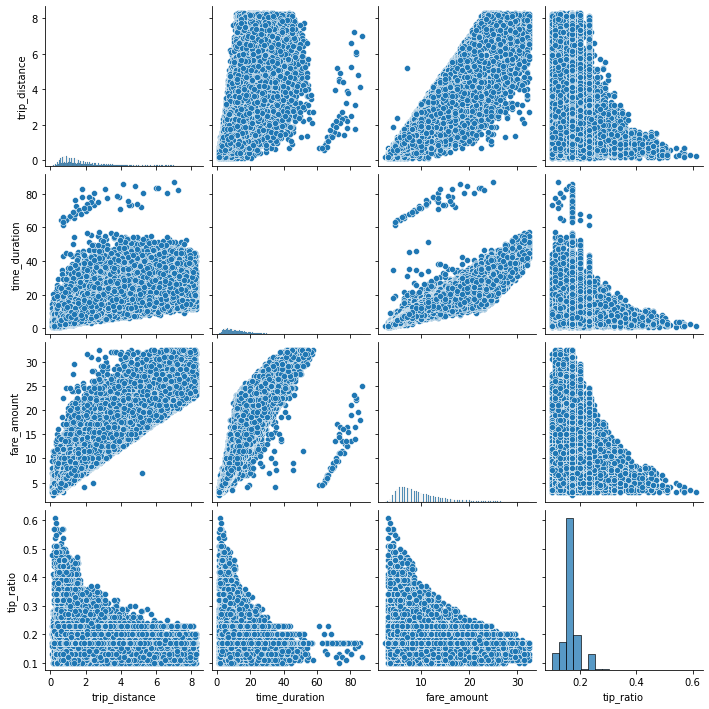

In [112]:
pairs = ['trip_distance', 'time_duration', 'fare_amount', 'tip_ratio']

sns.pairplot(yellow_standard_sample[pairs])
plt.savefig("../plots/Pair plot between distance duration fare tiptatio")

plt.show()

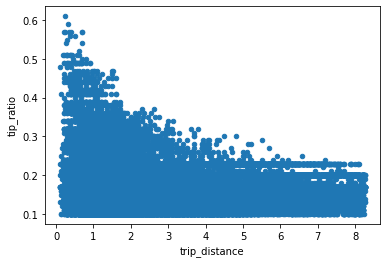

In [111]:
yellow_standard_sample[['trip_distance','tip_ratio']].plot.scatter(x='trip_distance', y='tip_ratio')

plt.show()

In [ ]:
yellow_standard_sample[['fare_amount', 'trip_distance']].plot.scatter(x='fare_amount', y='trip_distance')

plt.show()

#### Correlation Heatmap

In [ ]:
CORR_COLS = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'time_duration', 
             'tip_ratio', 'fare/hour', 'mile/hour', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG']

yellow_standard_sample[CORR_COLS].corr()

In [ ]:
sns.set(rc={'figure.figsize': (15,8)})

sns.heatmap(yellow_standard_sample[CORR_COLS].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1, linecolor='white')

plt.savefig("../plots/Correlation Heatmap")
plt.show()

## Statistical Modelling

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from statsmodels.formula.api import *

warnings.filterwarnings("ignore")

In [24]:
data = pd.read_feather("../preprocessed_data/yellow_standard_sample")

data = data.rename(columns={'mile/hour': 'mph'})

In [25]:
data

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,day_type,tip_ratio,fare/hour,mph,AWND,PRCP,SNOW,SNWD,TAVG,WT
0,2018-01-01 00:58:44,2018-01-01 01:09:53,1,1.50,1,170,79,8.5,1.96,11.76,...,Weekday,0.17,63.00,8.04,7.83,0.0,0.0,0.0,13.0,good
1,2018-01-01 18:33:14,2018-01-01 18:36:10,2,0.95,1,170,233,5.0,1.70,8.50,...,Weekday,0.20,175.86,19.66,7.83,0.0,0.0,0.0,13.0,good
2,2018-01-01 11:38:53,2018-01-01 11:57:09,2,3.90,1,162,211,16.0,3.35,20.15,...,Weekday,0.17,66.07,12.79,7.83,0.0,0.0,0.0,13.0,good
3,2018-01-01 20:32:58,2018-01-01 20:45:07,1,2.30,1,158,148,10.5,2.35,14.15,...,Weekday,0.17,69.59,11.31,7.83,0.0,0.0,0.0,13.0,good
4,2018-01-01 13:31:06,2018-01-01 13:36:05,1,1.10,1,68,186,6.0,1.35,8.15,...,Weekday,0.17,97.80,13.20,7.83,0.0,0.0,0.0,13.0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293011,2018-03-31 16:03:32,2018-03-31 16:11:05,1,1.00,1,163,142,6.5,1.00,8.30,...,Weekday,0.12,65.53,7.89,6.49,0.0,0.0,0.0,48.5,good
293012,2018-03-31 15:25:44,2018-03-31 15:41:37,1,2.22,1,211,164,11.5,2.46,14.76,...,Weekday,0.17,55.70,8.38,6.49,0.0,0.0,0.0,48.5,good
293013,2018-03-31 22:31:53,2018-03-31 22:44:02,1,1.94,1,48,164,10.0,2.26,13.56,...,Weekday,0.17,66.69,9.54,6.49,0.0,0.0,0.0,48.5,good
293014,2018-03-31 09:30:57,2018-03-31 09:37:37,1,1.20,1,43,239,7.0,1.80,9.60,...,Weekday,0.19,85.97,10.75,6.49,0.0,0.0,0.0,48.5,good


In [26]:
# Split data for validation

train_data = data.groupby('pickup_date').sample(frac=0.8, random_state=1)

test_data = data.drop(train_data.index)

Remove datetime;

Remove total amount as tip amount has strong relationship with it (ratio to it).

In [28]:
COL_FILTER = ['passenger_count', 'total_amount', 'fare_amount', 'tip_amount', 'trip_distance', 'time_duration', 
              'day_type', 'mph', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'WT']

train_data = train_data[COL_FILTER]
test_data = test_data[COL_FILTER]

In [29]:
train_data = train_data.reset_index().drop('index', axis=1)
test_data = test_data.reset_index().drop('index', axis=1)

train_data.to_feather("../preprocessed_data/train_data")
test_data.to_feather("../preprocessed_data/test_data")

### Visualisation on tip amount

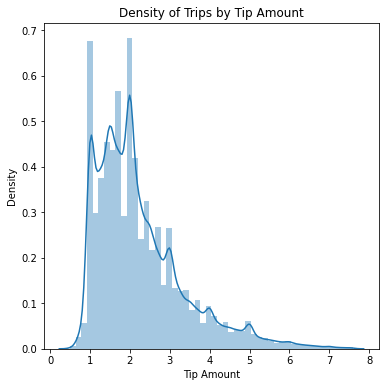

In [31]:
plt.figure(figsize=(6,6))
sns.distplot(data['tip_amount'], bins=50)
plt.title("Density of Trips by Tip Amount")
plt.xlabel("Tip Amount")

plt.show()


### Find fitter distribution
https://towardsdatascience.com/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

Large dataset could not be run successfully, so sample dataset is used. 

,sumsquare_error,aic,bic,kl_div
lognorm,1.678565,604.637571,-3.536678e+06,0.178062
beta,1.728674,631.777845,-3.528046e+06,0.192923
gamma,1.729104,628.328912,-3.527986e+06,0.193168
norm,2.389498,800.012588,-3.433214e+06,0.304381


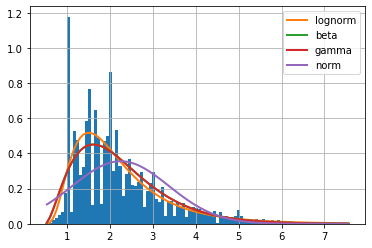

In [34]:
from fitter import Fitter

tip = data['tip_amount'].values

f = Fitter(tip, distributions=['gamma', 'lognorm', 'beta', 'norm'])
f.fit()

f.summary()

In [15]:
f.get_best(method = 'sumsquare_error')

{'norm': (2.2473278634842493, 1.1158257055633767)}

In [19]:
f.fitted_param["beta"]

(2.767519530655653, 2157859.72757468, 0.495444899929665, 1368243.1637088843)

### Fitting GLM with different exponential families

#### Inverse Gaussian distribution with log link function

https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use

If you are dealing with continuous non-negative outcome, then you could consider the Gamma distribution, or Inverse Gaussian distribution.

log-linear fit to the Gaussian is unsuitable; there's strong heteroskedasticity in the residuals. 

In [99]:
train_data = pd.read_feather("../preprocessed_data/train_data")

In [100]:
train_data

,passenger_count,total_amount,fare_amount,tip_amount,trip_distance,time_duration,day_type,mph,AWND,PRCP,SNOW,SNWD,TAVG,WT
0,1,7.55,5.0,1.25,0.90,3.9,Weekday,13.85,7.83,0.0,0.0,0.0,13.0,good
1,1,8.15,6.0,1.35,0.90,5.4,Weekday,10.00,7.83,0.0,0.0,0.0,13.0,good
2,1,12.00,9.0,1.70,1.70,9.6,Weekday,10.62,7.83,0.0,0.0,0.0,13.0,good
3,1,29.64,22.0,6.84,6.87,18.0,Weekday,22.90,7.83,0.0,0.0,0.0,13.0,good
4,1,19.56,15.0,3.26,4.33,12.6,Weekday,20.62,7.83,0.0,0.0,0.0,13.0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234408,1,23.75,17.0,5.45,4.10,21.0,Weekday,11.71,6.49,0.0,0.0,0.0,48.5,good
234409,1,29.75,23.5,4.95,7.40,23.6,Weekday,18.81,6.49,0.0,0.0,0.0,48.5,good
234410,2,31.56,25.0,5.26,7.38,28.1,Weekday,15.76,6.49,0.0,0.0,0.0,48.5,good
234411,2,9.95,7.0,1.65,1.00,7.9,Weekday,7.59,6.49,0.0,0.0,0.0,48.5,good


In [101]:
from statsmodels.api import families

fit_ig = glm(formula="tip_amount ~ passenger_count + fare_amount + trip_distance + time_duration + day_type + mph + AWND + PRCP + SNOW + SNWD + TAVG + WT",
         data=train_data, family=families.InverseGaussian(link=families.links.log)).fit()

print(fit_ig.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234400
Model Family:         InverseGaussian   Df Model:                           12
Link Function:                    log   Scale:                        0.035270
Method:                          IRLS   Log-Likelihood:            -1.6851e+05
Date:                Sun, 15 Aug 2021   Deviance:                       6910.1
Time:                        15:43:38   Pearson chi2:                 8.27e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0892    

In [36]:
fitter_ig = glm(formula="tip_amount ~ passenger_count + fare_amount + trip_distance + time_duration + day_type + mph + SNOW",
         data=train_data, family=families.InverseGaussian(link=families.links.log)).fit()

print(fitter_ig.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234405
Model Family:         InverseGaussian   Df Model:                            7
Link Function:                    log   Scale:                        0.035271
Method:                          IRLS   Log-Likelihood:            -1.6851e+05
Date:                Sun, 15 Aug 2021   Deviance:                       6910.4
Time:                        15:09:10   Pearson chi2:                 8.27e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0914    

Include the interaction

https://quantifyinghealth.com/why-and-when-to-include-interactions-in-a-regression-model/

In [37]:
fitter_interaction_ig = glm(formula="tip_amount ~ passenger_count + fare_amount*trip_distance + time_duration + day_type + mph + SNOW",
         data=train_data, family=families.InverseGaussian(link=families.links.log)).fit()

print(fitter_interaction_ig.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234404
Model Family:         InverseGaussian   Df Model:                            8
Link Function:                    log   Scale:                        0.034641
Method:                          IRLS   Log-Likelihood:            -1.6122e+05
Date:                Sun, 15 Aug 2021   Deviance:                       6427.9
Time:                        15:09:16   Pearson chi2:                 8.12e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [38]:
[fit_ig.aic, fitter_ig.aic,fitter_interaction_ig.aic], [fit_ig.bic, fitter_ig.bic,fitter_interaction_ig.bic]

([337042.2441017114, 337042.21663325, 322455.44224668544],
 [-2891408.386184715, -2891469.873248125, -2891939.964473839])

#### Gamma distribution with log link function

In [39]:
from statsmodels.api import families

fit_ga = glm(formula="tip_amount ~ passenger_count + fare_amount + trip_distance + time_duration + day_type + mph + AWND + PRCP + SNOW + SNWD + TAVG + WT",
         data=train_data, family=families.Gamma(link=families.links.log)).fit()

print(fit_ga.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234400
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.063202
Method:                          IRLS   Log-Likelihood:            -1.6190e+05
Date:                Sun, 15 Aug 2021   Deviance:                       13163.
Time:                        15:09:36   Pearson chi2:                 1.48e+04
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0285    

In [40]:
fitter_ga = glm(formula="tip_amount ~ passenger_count + fare_amount + trip_distance + time_duration + day_type + mph + AWND + SNOW + SNWD",
         data=train_data, family=families.Gamma(link=families.links.log)).fit()

print(fitter_ga.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234403
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                        0.063202
Method:                          IRLS   Log-Likelihood:            -1.6190e+05
Date:                Sun, 15 Aug 2021   Deviance:                       13163.
Time:                        15:10:02   Pearson chi2:                 1.48e+04
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0298    

In [41]:
fitter_interaction_ga = glm(formula="tip_amount ~ passenger_count + fare_amount*trip_distance + time_duration + day_type + mph + SNOW + SNWD",
         data=train_data, family=families.Gamma(link=families.links.log)).fit()

print(fitter_interaction_ga.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234403
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                        0.058990
Method:                          IRLS   Log-Likelihood:            -1.4909e+05
Date:                Sun, 15 Aug 2021   Deviance:                       11738.
Time:                        15:10:08   Pearson chi2:                 1.38e+04
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [42]:
[fit_ga.aic, fitter_ga.aic,fitter_interaction_ga.aic], [fit_ga.bic, fitter_ga.bic,fitter_interaction_ga.bic]

([323822.3126058157, 323817.1174058817, 298190.2633405799],
 [-2885155.359416485, -2885192.3890735316, -2886617.9638389926])

#### Gaussian distribution with log link function

In [102]:
from statsmodels.api import families

fit_gau = glm(formula="tip_amount ~ passenger_count + fare_amount + trip_distance + time_duration + day_type + mph + AWND + PRCP + SNOW + SNWD + TAVG + WT",
         data=train_data, family=families.Gaussian(link=families.links.log)).fit()

print(fit_gau.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234400
Model Family:                Gaussian   Df Model:                           12
Link Function:                    log   Scale:                         0.32600
Method:                          IRLS   Log-Likelihood:            -2.0124e+05
Date:                Sun, 15 Aug 2021   Deviance:                       76414.
Time:                        15:43:44   Pearson chi2:                 7.64e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1016    

In [103]:
fitter_gau = glm(formula="tip_amount ~ passenger_count + fare_amount + trip_distance + time_duration + day_type + mph + SNOW + SNWD",
         data=train_data, family=families.Gaussian(link=families.links.log)).fit()

print(fitter_gau.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234404
Model Family:                Gaussian   Df Model:                            8
Link Function:                    log   Scale:                         0.32600
Method:                          IRLS   Log-Likelihood:            -2.0124e+05
Date:                Sun, 15 Aug 2021   Deviance:                       76415.
Time:                        15:44:06   Pearson chi2:                 7.64e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0972    

In [104]:
fitter_interaction_gau = glm(formula="tip_amount ~ passenger_count + fare_amount*trip_distance + time_duration + day_type + mph + SNOW + SNWD",
         data=train_data, family=families.Gaussian(link=families.links.log)).fit()

print(fitter_interaction_gau.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             tip_amount   No. Observations:               234413
Model:                            GLM   Df Residuals:                   234403
Model Family:                Gaussian   Df Model:                            9
Link Function:                    log   Scale:                         0.27761
Method:                          IRLS   Log-Likelihood:            -1.8241e+05
Date:                Sun, 15 Aug 2021   Deviance:                       65073.
Time:                        15:44:08   Pearson chi2:                 6.51e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [105]:
[fit_gau.aic, fitter_gau.aic, fitter_interaction_gau.aic], [fit_gau.bic, fitter_gau.bic, fitter_interaction_gau.bic]

([402503.4996408033, 402497.9445318471, 364835.784116696],
 [-2821904.411553684, -2821953.073861032, -2833283.014375856])

#### Compare three models 

In [47]:
test_data = pd.read_feather("../preprocessed_data/test_data")

test_data.tail()

,passenger_count,total_amount,fare_amount,tip_amount,trip_distance,time_duration,day_type,mph,AWND,PRCP,SNOW,SNWD,TAVG,WT
58598,1,8.30,6.0,1.50,0.90,6.5,Weekday,8.31,6.49,0.0,0.0,0.0,48.5,good
58599,3,32.16,25.5,5.36,7.59,28.6,Weekday,15.92,6.49,0.0,0.0,0.0,48.5,good
58600,1,8.75,6.0,1.45,0.80,5.7,Weekday,8.42,6.49,0.0,0.0,0.0,48.5,good
58601,1,10.55,8.0,1.75,1.40,9.3,Weekday,9.03,6.49,0.0,0.0,0.0,48.5,good
58602,1,9.60,7.0,1.80,1.20,6.7,Weekday,10.75,6.49,0.0,0.0,0.0,48.5,good


In [48]:
y_true = test_data['tip_amount']
y_true

0        6.84
1        1.55
2        4.26
3        1.46
4        4.95
         ... 
58598    1.50
58599    5.36
58600    1.45
58601    1.75
58602    1.80
Name: tip_amount, Length: 58603, dtype: float64

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

- Inverse Gaussian

In [52]:
y_pred_ig = fitter_interaction_ig.predict(test_data)
y_pred_ig

0        4.638585
1        1.385961
2        4.617698
3        1.561883
4        4.264561
           ...   
58598    1.480917
58599    4.881410
58600    1.470929
58601    1.841618
58602    1.649606
Length: 58603, dtype: float64

In [53]:
r2_score(y_true, y_pred_ig)

0.7721945037586473

In [54]:
mean_squared_error(y_true, y_pred_ig)

0.28578799032251595

- Gamma

In [55]:
y_pred_ga = fitter_interaction_ga.predict(test_data)
y_pred_ga

0        4.704591
1        1.401430
2        4.648088
3        1.559616
4        4.237437
           ...   
58598    1.491582
58599    5.022017
58600    1.482627
58601    1.840759
58602    1.654356
Length: 58603, dtype: float64

In [56]:
r2_score(y_true, y_pred_ga)

0.7783587853798

In [57]:
mean_squared_error(y_true, y_pred_ga)

0.27805473679984943

- Gaussian

In [58]:
y_pred_gau = fitter_interaction_gau.predict(test_data)
y_pred_gau

0        4.758257
1        1.448450
2        4.641298
3        1.587699
4        4.159433
           ...   
58598    1.532374
58599    5.249694
58600    1.523857
58601    1.858654
58602    1.683695
Length: 58603, dtype: float64

In [59]:
r2_score(y_true, y_pred_gau)

0.7822147658389307

In [60]:
mean_squared_error(y_true, y_pred_gau)

0.2732173078338235

In [61]:
fitter_interaction_gau.params

Intercept                   -0.097284
day_type[T.Weekend]         -0.022228
passenger_count              0.002152
fare_amount                  0.094077
trip_distance                0.171277
fare_amount:trip_distance   -0.007693
time_duration               -0.010148
mph                         -0.010729
SNOW                         0.001582
SNWD                         0.000730
dtype: float64

In [62]:
fitter_interaction_gau.conf_int()

,0,1
Intercept,-0.103176,-0.091392
day_type[T.Weekend],-0.025074,-0.019382
passenger_count,0.001458,0.002847
fare_amount,0.092585,0.095570
trip_distance,0.168083,0.174471
fare_amount:trip_distance,-0.007772,-0.007614
time_duration,-0.010801,-0.009496
mph,-0.011196,-0.010263
SNOW,0.000706,0.002458
SNWD,0.000191,0.001269


### Predict the future data

In [116]:
future_data = pd.read_feather("../preprocessed_data/yellow_tripdata_2019-1-2-3_standard_no_outliers")

future_data = future_data.rename(columns={'mile/hour': 'mph'})

In [117]:
y_true_future = future_data['tip_amount']
y_true_future

0           1.65
1           1.25
2           3.70
3           1.70
4           3.25
            ... 
12214163    1.96
12214164    5.36
12214165    1.66
12214166    2.79
12214167    2.33
Name: tip_amount, Length: 12214168, dtype: float64

In [106]:
y_pred_gaussian = fitter_interaction_gau.predict(future_data)
y_pred_gaussian

0           1.694631
1           1.623790
2           3.038192
3           2.251262
4           3.199275
              ...   
12214163    1.451430
12214164    4.897935
12214165    1.263742
12214166    1.389647
12214167    1.427267
Length: 12214168, dtype: float64

In [114]:
r2_score(y_true_future, y_pred_gau)

0.670101429794411

In [119]:
mean_squared_error(y_true_future, y_pred_gau)

0.4344898022472394